<a href="https://colab.research.google.com/github/liuy01510/portfolio/blob/master/Python/ML/Regression_Models/Regression_Classifier_(Diabetes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading required modules

In [311]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import warnings

In [312]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, precision_recall_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Loading the dataset

In [313]:
data=fetch_openml(data_id=37)

In [314]:
type(data) # show the data type

sklearn.utils.Bunch

In [315]:
data.keys() # show the keys of the bunch object

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [316]:
# Extracting the data from the keys
X=data['data']
y=data['target']
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Cleaning up the target data
target_labels=list(set(y))
target_dict={}
for i,j in zip(target_labels,[0,1]):
    target_dict[i]=j

y=np.vectorize(target_dict.get)(y)

Feature shape: (768, 8)
Target shape: (768,)


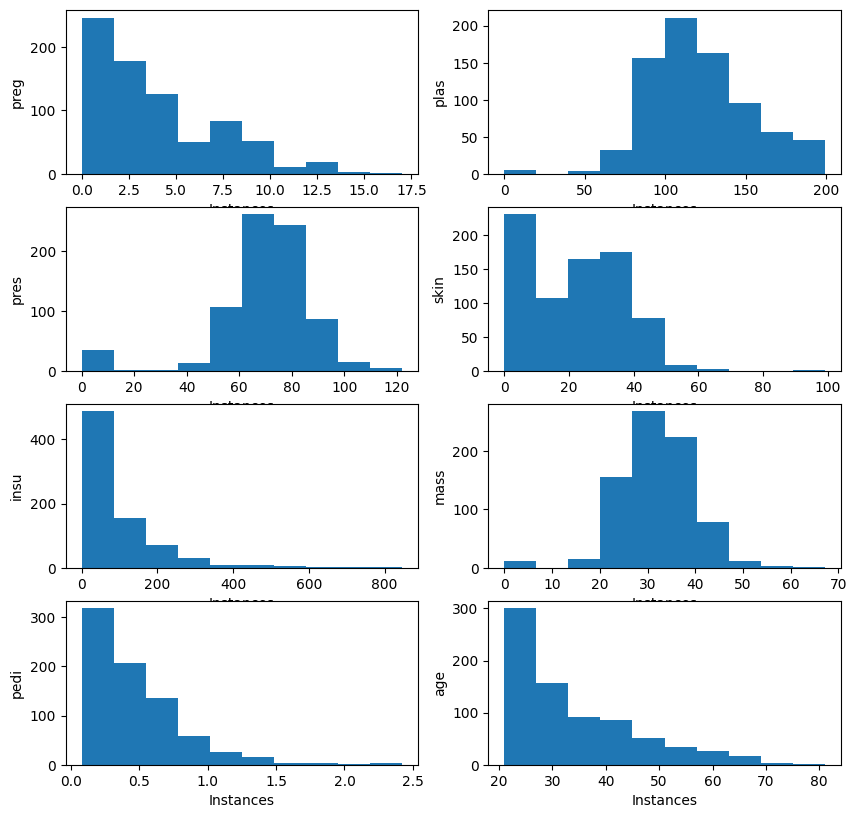

In [317]:
# Visualizing the data
X_frame=pd.DataFrame(X,columns=data['feature_names']) # creating a dataframe to store the data

# Creating subplots
fig=plt.Figure(figsize=(10,10),dpi=100)
subplots=fig.subplots(nrows=4,ncols=2) # 4 rows, 2 cols
subplots=subplots.flatten() # flatten out to 1d array


# Visualizing the data
for i,col in enumerate(X_frame.columns):
    subplot=subplots[i]
    subplot.hist(X_frame[col])
    subplot.set_ylabel(col)
    subplot.set_xlabel('Instances')

fig

In [318]:
# Performing standard scaling
standard_scaler=StandardScaler() # perform standard scaling

# Training the regression classifier model

In [319]:
# Creating the training and test sets
target_dict={}
target_dict['tested_negative']=0
target_dict['tested_positive']=1


X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,shuffle=True)

X_train=standard_scaler.fit_transform(X_train) # fitting on the train set
X_test=standard_scaler.transform(X_test) # recall that the test set should be transform solely based on the training set parameters
# the whole feature set shouldn't be trained together, since the test set presence may affect the scaling as well.

# Creating and training the log reg model
logReg=LogisticRegression(max_iter=1000) # default with l2 regression
y_pred=cross_val_predict(logReg,X_train,y_train,cv=5) # clean cv training and prediction

In [320]:
# Plotting the confusion matrix to evaluate classifier performance
labels=list(set(y_train))
cf_matrix=confusion_matrix(y_train,y_pred,labels=labels)
print(f"False Negatives = {cf_matrix[0,1]}")
print(f"False Positives = {cf_matrix[1,0]}")

# Calculating the recall and precision
print(f"Precision Score = {precision_score(y_train,y_pred)*100:.2f}%")
print(f"Recall Score = {recall_score(y_train,y_pred)*100:.2f}%")
print(f"F1 Score = {f1_score(y_train,y_pred)*100:.2f}%")

False Negatives = 45
False Positives = 93
Precision Score = 72.22%
Recall Score = 55.71%
F1 Score = 62.90%


- The precision and recall scores are quite low for this model, which implies that the model is unsuitable for deployment.

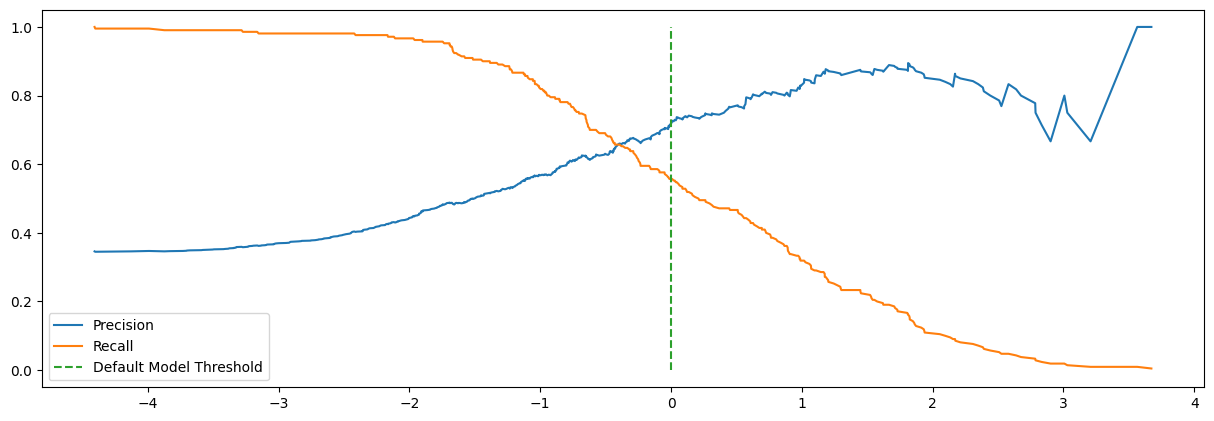

In [321]:
# Plotting the Precision-Recall curve
logReg=LogisticRegression(max_iter=1000)
y_pred_prob=cross_val_predict(logReg,X_train,y_train,cv=5,method='decision_function') # returns the threshold/confidence values instead of predictions
precision,recall,threshold=precision_recall_curve(y_train,y_pred_prob)

def Plot(figsize=(7,7),dpi=300):
    fig=plt.Figure(figsize=figsize,dpi=dpi)
    ax=fig.add_subplot(111)
    return ax,fig

ax,fig=Plot(figsize=(15,5),dpi=100)
ax.plot(threshold,precision[:-1],label='Precision')
ax.plot(threshold,recall[:-1],label='Recall')
ax.plot([0,0],[0,1],'--',label='Default Model Threshold')
ax.legend()
fig

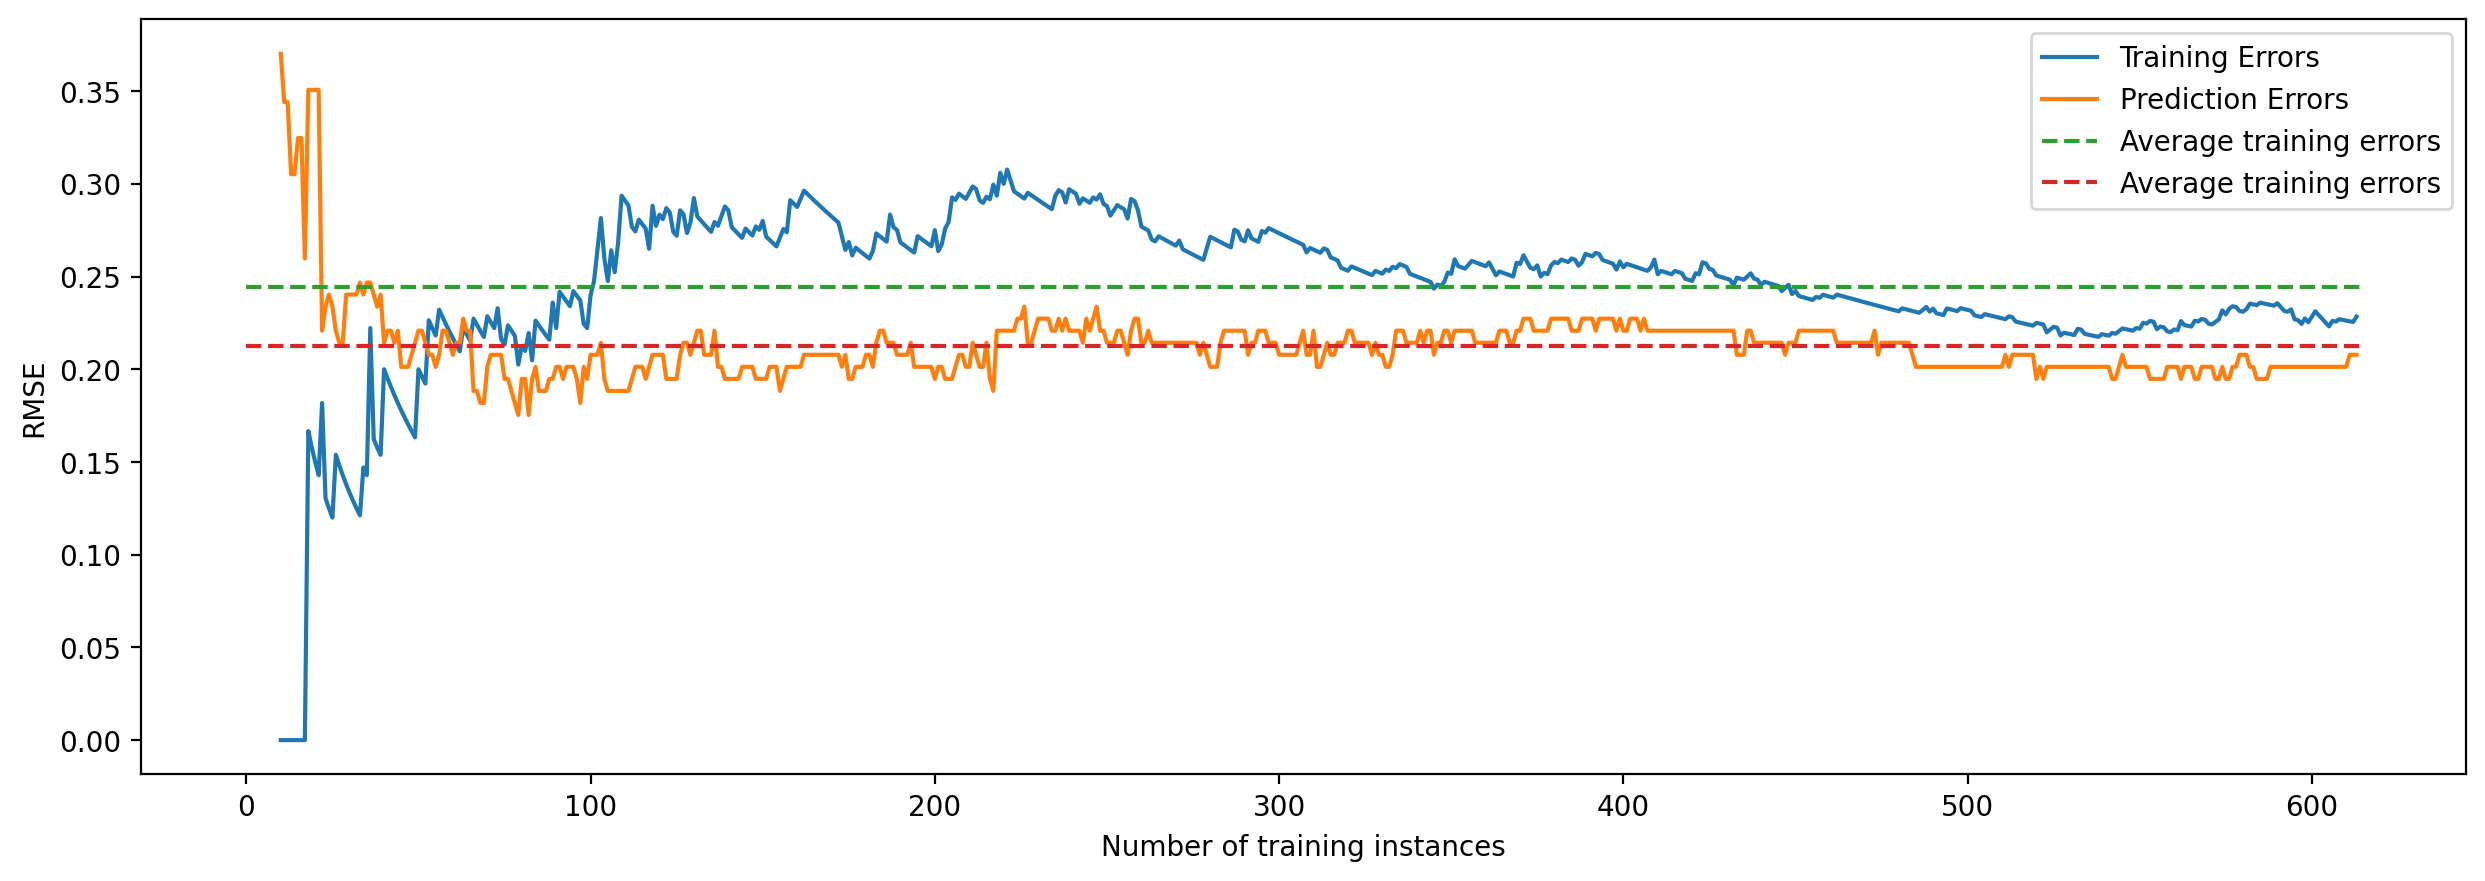

In [322]:
# Checking the fitting of the model
def Learning_Curves(model,X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True) # creating the train and test sets
    train_errors,pred_errors=[],[] # contains the errors vals
    m=10 # Min number of samples to start training
    for i in range(m,len(y_train)):
        model.fit(X_train[:i,:],y_train[:i]) # train only a subset of the available data

        y_train_pred=model.predict(X_train[:i]) # predict the training set data to generate the train errors
        train_errors.append(mean_squared_error(y_train[:i],y_train_pred)) # RMSE of training errors

        y_pred=model.predict(X_test) # predictions on the testing data
        pred_errors.append(mean_squared_error(y_test,y_pred)) # RMSE of the prediction errors

    # Data plotting

    fig=plt.Figure(figsize=(15,5),dpi=200)
    ax=fig.add_subplot(111)
    ax.plot(list(range(m,len(y_train))),train_errors,label='Training Errors')
    ax.plot(list(range(m,len(y_train))),pred_errors,label='Prediction Errors')

    avg_training_error=sum(train_errors)/len(train_errors) # obtaining the average training errors
    avg_pred_error=sum(pred_errors)/len(pred_errors) # obtaining the average validation errors
    ax.plot([0,len(y_train)],[avg_training_error]*2,'--',label='Average training errors')
    ax.plot([0,len(y_train)],[avg_pred_error]*2,'--',label='Average training errors')

    ax.set_ylabel('RMSE')
    ax.set_xlabel('Number of training instances')
    ax.legend()
    return fig

# Plotting the learning curves
logReg=LogisticRegression(max_iter=1000,n_jobs=-1)
fig=Learning_Curves(logReg,X,y)
fig

# Observations
- RMSE is not a suitable metric for the evaluation of classifier models.
    - However, in this case, since a binary classifier is used, it can be used for a rough visualization of the training and validation errors.
    - It provides a rough insight on how the training and validation instances behave relative to the number of training instances, but the absolute RMSE value is not useful in this case.
- The prediction errors seems to plateau early on in the model, which implies that additional instances will not help to reduce the validation errors of this model.
- The training errors displays signs of overfitting at the start, with the large difference between the validation and training errors.
    - However, overfitting of the dataset becomes less of an issue when the model receives more instances for training.
- Therefore, procuring additional instances will not be useful for improving the performance of this model.

# Improving the model performance

## Polynomial Features

In [323]:
# Implementing polynomial features
polynomial_features=PolynomialFeatures(degree=5)
X_poly_train=polynomial_features.fit_transform(X_train)

logReg=LogisticRegression(max_iter=1000)
y_pred=cross_val_predict(logReg,X_poly_train,y_train,cv=5)

def scoring(y_pred,y_true):
    print(f"Precision Score = {precision_score(y_true,y_pred)*100:.2f}%")
    print(f"Recall Score = {recall_score(y_true,y_pred)*100:.2f}%")
    print(f"F1 Score = {f1_score(y_true,y_pred)*100:.2f}%")

scoring(y_pred,y_train)

Precision Score = 56.04%
Recall Score = 55.24%
F1 Score = 55.64%


- It appears that the implementation of polynomial features has resulted in a lower F1 score, so it is inadvisible in this case.

## Early Stopping of the model

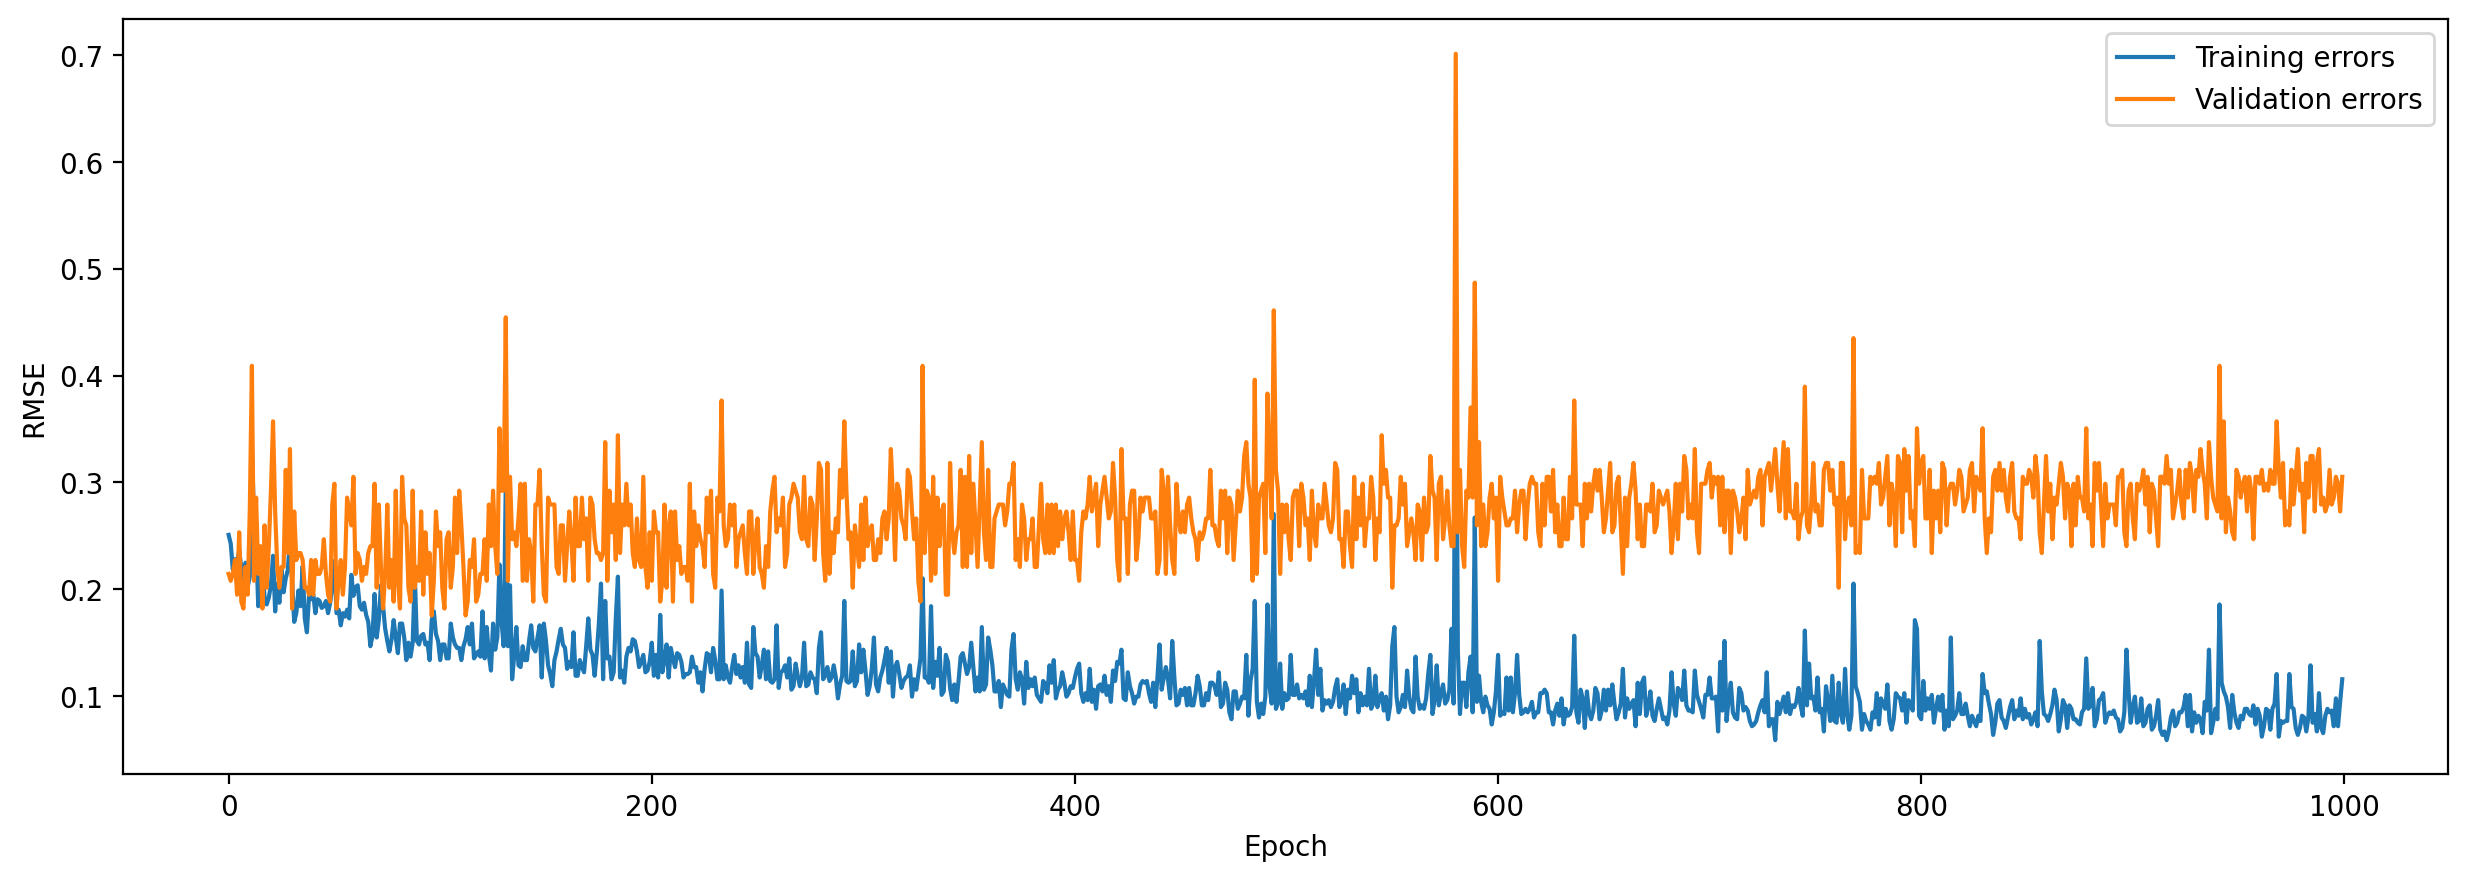

In [324]:
# Creating the polynomial features

warnings.filterwarnings('ignore') # ignore all warnings - Stops all ConvergenceWarning

X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=True,test_size=0.2)
# recreating non-standardized data
polynomial_features=PolynomialFeatures(degree=7)
X_poly_train,X_poly_test=polynomial_features.fit_transform(X_train),polynomial_features.fit_transform(X_test)
# create poly features
standard_scaler=StandardScaler() # create standard scaler object
X_poly_train=standard_scaler.fit_transform(X_poly_train) # fit and transform the training instances
X_poly_test=standard_scaler.transform(X_poly_test) # transform the test instances based on the training instances params

sgd_reg=SGDClassifier(penalty=None,max_iter=1,warm_start=True,learning_rate='constant',eta0=0.001,n_jobs=-1)
# penalty = None because no regularization is employed for the early stopping method.
    # recall that early stopping method is supposed to stop when overfitting occurs
    # overfitting errors occurs when the validation errors begins to increase
# max_iter = 1 because the model should only take 1 "step" for each epoch
# warm_start = True to allow model to resume training instead of starting afresh
# learning_rate = 'constant' in order to allow for a regular step size for each epoch
    # step size will be chosen arbitarily initially then further refined

train_errors,validation_errors=[],[]
for e in range(1000): # 100 epoches chosen
    sgd_reg.fit(X_poly_train,y_train) # perform 1 round of training
    train_pred=sgd_reg.predict(X_poly_train) # prediction of the training data
    test_pred=sgd_reg.predict(X_poly_test) # prediction of the test data
    train_errors.append(mean_squared_error(y_train,train_pred)) # training errors
    validation_errors.append(mean_squared_error(y_test,test_pred)) # validation errors

ax,fig=Plot(figsize=(15,5),dpi=200)
ax.plot([i for i in range(1000)],train_errors,label='Training errors')
ax.plot([i for i in range(1000)],validation_errors,label='Validation errors')
ax.set_ylabel('RMSE')
ax.set_xlabel('Epoch')
ax.legend()

warnings.filterwarnings('default') # return default warning behaviour

fig

- Similar to the above Learning Curves plot, the absolute RMSE values for this plot should not used, since it is only useful for a rough visualization of the data trend.
- The above plot shows that despite having polynomial features of up to 7th order, the validation errors remains constant.
    - Issue with model is not due to the overfitting of the model, based on the conclusions from the above plot.
- Therefore, there are several other posibilities to tune the model.
    - Running a GridSearchCV to estimate better hyperparameters for the model.
- However, it is likely that the simple regression classifier model used is insufficient to provide reasonable performance.
    - As such, other models should be considered.